In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

C:\Users\rayso\AppData\Local\conda\conda\envs\tensorflow_env\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [3]:
mnist = input_data.read_data_sets('data')
imgs_raw, label = mnist.train.next_batch(500)
imgs_bin = np.where(imgs_raw < 0.5, -1, 1)

Extracting data\train-images-idx3-ubyte.gz
Extracting data\train-labels-idx1-ubyte.gz
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz


In [4]:
def get_square_neighbour_dict(size):
    dict = {}
    for i in range(size):
        for j in range(size):
            if i == 0 and j == 0:
                dict[i*size+j] = {i*size+j+1, i*size+j+size}
            elif i == 0 and j == size-1:
                dict[i*size+j] = {i*size+j-1, i*size+j+size}
            elif i == 0:
                dict[i*size+j] = {i*size+j-1, i*size+j+1, i*size+j+size}
            elif i == size-1 and j == 0:
                dict[i*size+j] = {i*size+j+1, i*size+j-size}
            elif i == size-1 and j == size-1:
                dict[i*size+j] = {i*size+j-1, i*size+j-size}
            elif i == size-1:
                dict[i*size+j] = {i*size+j-1, i*size+j+1, i*size+j-size}  
            elif j == 0:
                dict[i*size+j] = {i*size+j+1, i*size+j-size, i*size+j+size}
            elif j == size-1:
                dict[i*size+j] = {i*size+j-1, i*size+j-size, i*size+j+size} 
            else:
                dict[i*size+j] = {i*size+j-1, i*size+j+1, i*size+j-size, i*size+j+size}
    return dict
    

In [5]:
imgs_noise = np.where(np.random.rand(500,784)<0.02, -imgs_bin, imgs_bin)
nbr_dict = get_square_neighbour_dict(28)

In [12]:
class BinaryImageMeanFieldInferenceDenoiser():
    def __init__(self, nbr_dict, theta_nbr, theta_noisyData, max_iter = 10):
        self.nbr_dict = nbr_dict
        self.theta_nbr = theta_nbr
        self.theta_noisyData = theta_noisyData
        self.max_iter = max_iter
    
    def denoise(self, img_batch):
        # Input img is binary image, with -1 and 1 value
        # TODO: 1. add check if input img is binarized to -1, 1 value, if not binarize img to -1, 1 
        # Input noisy img_batch of shape: batch_size * img_size (linearized, i.e. img_size = width * height)
        # TODO: 2. modify to accept different cases: single image without batch dimention; img not linearized etc
        batch_size = img_batch.shape[0]
        img_size = img_batch.shape[1]
        
        probs = np.ones((batch_size,img_size))*0.5
        
        # TODO: 3. below ways of denoising uses latest neightbour prob to infer the current prob. 
        # We could vectorize by comprimising not to use latest neightbour prob by applying a kinda mask layer that aggregates neighbour prob values
        # In this way, we could have faster iterations, but might require more iteration. Overall, performance should be faster
        for n_iter in range(self.max_iter):
            for i in range(img_size):
                probs[:,i] = np.exp(np.sum((np.array([probs[:,j] for j in self.nbr_dict[i]])*2-1)*self.theta_nbr, axis=0)+img_batch[:,i]*self.theta_noisyData)/(
                    np.exp(-np.sum((np.array([probs[:,j] for j in self.nbr_dict[i]])*2-1)*self.theta_nbr, axis=0)-img_batch[:,i]*self.theta_noisyData)+
                    np.exp(np.sum((np.array([probs[:,j] for j in self.nbr_dict[i]])*2-1)*self.theta_nbr, axis=0)+img_batch[:,i]*self.theta_noisyData))
        
        # TODO: update return data to align with TODO.1 and TODO.2 
        return np.where(probs<0.5,-1,1)         
        

In [13]:
denoiser = BinaryImageMeanFieldInferenceDenoiser(nbr_dict=nbr_dict, theta_nbr=0.2, theta_noisyData=0.2, max_iter = 10)
imgs_denoise = denoiser.denoise(imgs_noise)

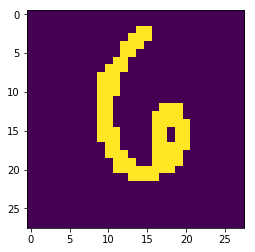

0.9770408163265306


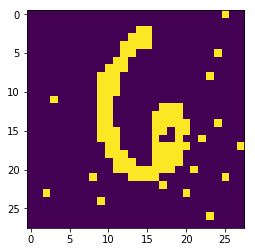

0.9948979591836735


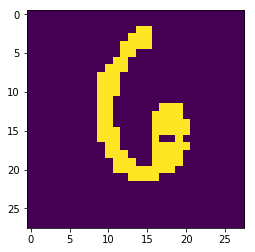

In [14]:
plt.imshow((imgs_bin[100].reshape(28,28)+1)/2)
plt.show()
print(np.mean(imgs_noise[100]==imgs_bin[100]))
plt.imshow((imgs_noise[100].reshape(28,28)+1)/2)
plt.show()
print(np.mean(imgs_denoise[100]==imgs_bin[100]))
plt.imshow((imgs_denoise[100].reshape(28,28)+1)/2)
plt.show()